In [1]:
%cd ../code

/home/chickencurry/markup-ocr/experiments/seq2seq/encoder-decoder/code


In [2]:
from data import LatexEquationDataset, LatexEquationSampler, create_tokenizer, load_tokenizer, load_img_names_from_path, curry_collate_fn, clean, create_img_names_to_skip, create_img_names_max_height
from model import EncoderDecoder

import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, random_split
from torchmetrics import CharErrorRate, WordErrorRate, BLEUScore
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

privateuseone:0


In [4]:
equations_path = "../data/formulae/math.txt"
tokenizer_path = "../data/my_tokenizer.json"

img_train_dir = "../data/formulae/train"
img_val_dir = "../data/formulae/val"
img_test_dir = "../data/formulae/test"

img_train_names_to_skip_path = "../data/img_train_names_to_skip.pkl"
img_val_names_to_skip_path = "../data/img_val_names_to_skip.pkl"
img_test_names_to_skip_path = "../data/img_names_to_skip.pkl"

train_indices_path = "../data/train_indices.pkl"

img_train_max_height_64_path = "../data/img_train_max_height_64.pkl"
img_train_max_height_32_path = "../data/img_train_max_height_32.pkl"

img_train_max_height_64_indices_path = "../data/img_train_max_height_64_indices.pkl"
img_train_max_height_32_indices_path = "../data/img_train_max_height_32_indices.pkl"

In [5]:
# create_tokenizer(equations_path, tokenizer_path)
tokenizer = load_tokenizer(tokenizer_path)

/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# create_img_names_to_skip(img_train_dir, img_train_names_to_skip_dir)
img_train_names_to_skip = load_img_names_from_path(img_train_names_to_skip_path)

# create_img_names_to_skip(img_val_dir, img_val_names_to_skip_dir)
img_val_names_to_skip = load_img_names_from_path(img_val_names_to_skip_path)

# create_img_names_max_height(img_train_dir, img_train_max_height_32_path, 32)
img_train_max_height_32 = load_img_names_from_path(img_train_max_height_32_path)

In [7]:
train_dataset = LatexEquationDataset(equations_path, img_train_dir, tokenizer, img_train_max_height_32, img_train_names_to_skip)
val_dataset = LatexEquationDataset(equations_path, img_val_dir, tokenizer, None, img_val_names_to_skip)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=False, 
    sampler=LatexEquationSampler(train_dataset, img_train_max_height_32_indices_path), 
    collate_fn=curry_collate_fn(tokenizer),
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=curry_collate_fn(tokenizer)
)

In [8]:
# img_batch, token_ids_batch, token_ids_mask_batch, target_token_ids_batch = next(iter(train_dataloader))
    
# for (img, token_ids, token_ids_mask, target_token_ids) in zip(img_batch, token_ids_batch, token_ids_mask_batch, target_token_ids_batch):

#     tokens = tokenizer.convert_ids_to_tokens(token_ids.tolist(), skip_special_tokens = True)
#     print(clean("".join(tokens)))

#     # print(token_ids_mask.shape)
#     # print(token_ids_mask)

#     plt.figure()
#     plt.axis("off")
#     plt.imshow(img.squeeze(0), cmap="gray")
#     plt.show()

In [9]:
model = EncoderDecoder(
    vocab_size=tokenizer.vocab_size,
    d_feature=768,
    d_model=256,
    n_blocks_enc=4,
    n_blocks_dec=4,
    n_heads=8,
    d_hidden=1024,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids("[PAD]"), label_smoothing=0.1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [10]:
train_loss = []
num_epochs = 1

for epoch in range(num_epochs):
    
    model.train()
    torch.inference_mode(False)

    train_iterator = tqdm(train_dataloader, total=len(train_dataloader), desc="training epoch {}/{}".format(epoch, num_epochs))

    for img, input_token_ids, padding_mask, target_token_ids in train_iterator:
        # move to GPU
        img = img.to(device)
        input_token_ids = input_token_ids.to(device)
        padding_mask = padding_mask.to(device)
        causal_mask = torch.triu(
            torch.full((input_token_ids.shape[1], input_token_ids.shape[1]), True),
            diagonal=1,
        ).to(device)
        target_token_ids = target_token_ids.to(device)

        # forward
        logits = model(img, input_token_ids, padding_mask, causal_mask)
        loss = criterion(logits, target_token_ids)

        # collect stats
        train_loss.append(loss.item())
        train_iterator.set_postfix({"loss": f"{loss.item():.4f}"})

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

training epoch 0/1:   0%|          | 0/2353 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torchvision/models/swin_transformer.py:167: UserWarning: The operator 'aten::roll' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))
training epoch 0/1:  20%|██        | 478/2353 [25:34<1:40:17,  3.21s/it, loss=nan]   


KeyboardInterrupt: 

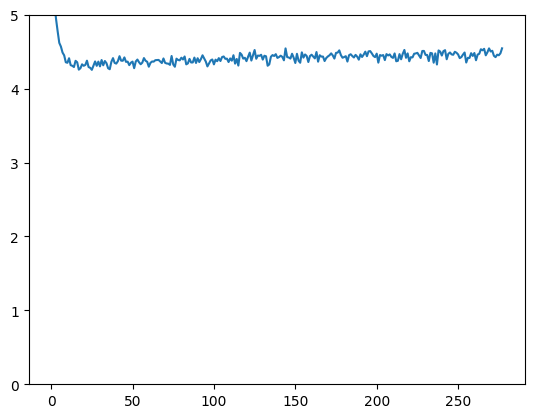

In [11]:
plt.plot(train_loss)
plt.ylim(0, 5)
plt.show()

In [ ]:
output_texts = []
target_texts = []

model.eval()
torch.inference_mode(True)

validation_iterator = tqdm(val_dataloader, total=len(val_dataloader), desc="validation epoch {}/{}".format(epoch, num_epochs))

for index, (img, token_ids) in tqdm(val_dataloader):
    # move to GPU
    img = img.to(device)
    input_token_ids = get_input_token_ids(token_ids, tokenizer).to(device)
    target_token_ids = get_target_token_ids(token_ids, tokenizer).to(device)

    # forward
    logits = model(img, input_token_ids)
    
    # collect stats
    output_texts.append(tokenizer.convert_ids_to_tokens(input_token_ids[0].tolist(), skip_special_tokens = True))
    target_texts.append(tokenizer.convert_ids_to_tokens(target_token_ids[0].tolist(), skip_special_tokens = True))

bleu = BLEUScore()(output_texts, target_texts)
wer = WordErrorRate()(output_texts, target_texts)
cer = CharErrorRate()(output_texts, target_texts)

print(f"BLEU: {bleu}")
print(f"WER: {wer}")
print(f"CRE: {cer}")